# 1.26c: Thimble 3 Bit-Level ULP Analysis

**Question:** Are predicted and observed W[t] different by **exactly one mantissa bit**?

We're going to decode the actual IEEE 754 bfloat16 representation and check:
1. Do they have the same exponent? (If not, skip—too different)
2. Do the mantissas differ by exactly 1?

**Bfloat16 format:**
```
[sign: 1 bit][exponent: 8 bits][mantissa: 7 bits]
```

If we're truly matching PyTorch's bfloat16 pipeline, most differences should be:
- Same exponent
- Mantissa differs by 0 or 1

Let's find out. 🔬

## Imports

In [16]:
import torch
import numpy as np
from pathlib import Path
from safetensors.torch import load_file
import matplotlib.pyplot as plt
import struct

## Bfloat16 Bit Decoder

In [17]:
def decode_bfloat16(x):
    """
    Decode bfloat16 into sign, exponent, mantissa.
    
    Returns:
        sign: 0 or 1
        exponent: 8-bit value (0-255)
        mantissa: 7-bit value (0-127)
    """
    # Convert to float32 first (bfloat16 is just float32 with lower 16 bits zeroed)
    f32 = x.float()
    
    # Get raw bits as uint32
    bits = torch.tensor(struct.unpack('>I', struct.pack('>f', f32.item()))[0], dtype=torch.int64)
    
    # Extract bfloat16 components (upper 16 bits of float32)
    sign = (bits >> 31) & 1
    exponent = (bits >> 23) & 0xFF
    mantissa = (bits >> 16) & 0x7F  # Only 7 bits for bfloat16
    
    return sign.item(), exponent.item(), mantissa.item()

# Test
test_val = torch.tensor(0.02, dtype=torch.bfloat16)
sign, exp, mant = decode_bfloat16(test_val)
print(f'Test value: {test_val.item():.6f}')
print(f'  Sign: {sign}')
print(f'  Exponent: {exp} (0x{exp:02x})')
print(f'  Mantissa: {mant} (0x{mant:02x}, binary: {mant:07b})')

Test value: 0.020020
  Sign: 0
  Exponent: 121 (0x79)
  Mantissa: 36 (0x24, binary: 0100100)


## Load Thimble 3 Data

In [18]:
data = load_file('../tensors/Thimble/thimble_3.safetensors')

W = data['W']
momentum_W = data['momentum_W']
variance_W = data['variance_W']

lr = data['learning_rate'].item()
beta1 = data['adam_beta1'].item()
beta2 = data['adam_beta2'].item()
eps = data['adam_epsilon'].item()

print(f'Loaded Thimble 3 data')
print(f'  W: {W.shape}, dtype={W.dtype}')

Loaded Thimble 3 data
  W: torch.Size([1001, 10000, 64]), dtype=torch.bfloat16


## Bit-Level Analysis: Sample Timestep

In [19]:
# Test on one timestep first
t = 100

print(f'Analyzing timestep t={t}...\n')

# Predict W[t]
m_t = momentum_W[t]
v_t = variance_W[t]
W_prev = W[t-1]

bias_correction1 = 1 - beta1**t
bias_correction2 = 1 - beta2**t

m_hat = (m_t.float() / bias_correction1).bfloat16()
v_hat = (v_t.float() / bias_correction2).bfloat16()
dW = (-lr * m_hat.float() / (torch.sqrt(v_hat.float()) + eps)).bfloat16()
predicted_W = (W_prev.float() + dW.float()).bfloat16()

observed_W = W[t]

# Flatten for analysis
pred_flat = predicted_W.flatten()
obs_flat = observed_W.flatten()

# Bit-level comparison
same_exponent = 0
mantissa_diff_0 = 0
mantissa_diff_1 = 0
mantissa_diff_2 = 0
mantissa_diff_larger = 0
different_exponent = 0

# Sample 1000 random elements (analyzing all 640k is slow)
n_samples = min(1000, len(pred_flat))
indices = torch.randperm(len(pred_flat))[:n_samples]

for idx in indices:
    pred_val = pred_flat[idx]
    obs_val = obs_flat[idx]
    
    # Decode both
    sign_p, exp_p, mant_p = decode_bfloat16(pred_val)
    sign_o, exp_o, mant_o = decode_bfloat16(obs_val)
    
    # Compare
    if exp_p == exp_o:
        same_exponent += 1
        mant_diff = abs(mant_p - mant_o)
        
        if mant_diff == 0:
            mantissa_diff_0 += 1
        elif mant_diff == 1:
            mantissa_diff_1 += 1
        elif mant_diff == 2:
            mantissa_diff_2 += 1
        else:
            mantissa_diff_larger += 1
    else:
        different_exponent += 1

print(f'Sampled {n_samples} elements:')
print(f'  Same exponent: {same_exponent} ({same_exponent/n_samples*100:.1f}%)')
print(f'    Mantissa diff = 0: {mantissa_diff_0} ({mantissa_diff_0/n_samples*100:.1f}%)')
print(f'    Mantissa diff = 1: {mantissa_diff_1} ({mantissa_diff_1/n_samples*100:.1f}%)')
print(f'    Mantissa diff = 2: {mantissa_diff_2} ({mantissa_diff_2/n_samples*100:.1f}%)')
print(f'    Mantissa diff > 2: {mantissa_diff_larger} ({mantissa_diff_larger/n_samples*100:.1f}%)')
print(f'  Different exponent: {different_exponent} ({different_exponent/n_samples*100:.1f}%)')

Analyzing timestep t=100...

Sampled 1000 elements:
  Same exponent: 1000 (100.0%)
    Mantissa diff = 0: 991 (99.1%)
    Mantissa diff = 1: 9 (0.9%)
    Mantissa diff = 2: 0 (0.0%)
    Mantissa diff > 2: 0 (0.0%)
  Different exponent: 0 (0.0%)


## Full Analysis: All Timesteps

In [20]:
print('\nAnalyzing all 1000 timesteps (sampling 500 elements per timestep)...\n')

results = []
n_samples_per_step = 500

for t in range(1, 1001):
    # Predict
    m_t = momentum_W[t]
    v_t = variance_W[t]
    W_prev = W[t-1]
    
    bias_correction1 = 1 - beta1**t
    bias_correction2 = 1 - beta2**t
    
    m_hat = (m_t.float() / bias_correction1).bfloat16()
    v_hat = (v_t.float() / bias_correction2).bfloat16()
    dW = (-lr * m_hat.float() / (torch.sqrt(v_hat.float()) + eps)).bfloat16()
    predicted_W = (W_prev.float() + dW.float()).bfloat16()
    
    observed_W = W[t]
    
    # Sample and compare
    pred_flat = predicted_W.flatten()
    obs_flat = observed_W.flatten()
    indices = torch.randperm(len(pred_flat))[:n_samples_per_step]
    
    same_exp = 0
    mant_0 = 0
    mant_1 = 0
    
    for idx in indices:
        sign_p, exp_p, mant_p = decode_bfloat16(pred_flat[idx])
        sign_o, exp_o, mant_o = decode_bfloat16(obs_flat[idx])
        
        if exp_p == exp_o:
            same_exp += 1
            mant_diff = abs(mant_p - mant_o)
            if mant_diff == 0:
                mant_0 += 1
            elif mant_diff == 1:
                mant_1 += 1
    
    results.append({
        't': t,
        'pct_same_exp': same_exp / n_samples_per_step * 100,
        'pct_mant_0': mant_0 / n_samples_per_step * 100,
        'pct_mant_1': mant_1 / n_samples_per_step * 100,
    })

import pandas as pd
df = pd.DataFrame(results)

print('=== Bit-Level Analysis Summary ===')
print(f'Average across all timesteps:')
print(f'  Same exponent: {df["pct_same_exp"].mean():.1f}%')
print(f'  Exact match (mantissa diff = 0): {df["pct_mant_0"].mean():.1f}%')
print(f'  Off by 1 mantissa bit: {df["pct_mant_1"].mean():.1f}%')
print()
print('Sample timesteps:')
print(df.iloc[[0, 9, 49, 99, 499, 999]].to_string(index=False))


Analyzing all 1000 timesteps (sampling 500 elements per timestep)...

=== Bit-Level Analysis Summary ===
Average across all timesteps:
  Same exponent: 100.0%
  Exact match (mantissa diff = 0): 99.0%
  Off by 1 mantissa bit: 0.9%

Sample timesteps:
   t  pct_same_exp  pct_mant_0  pct_mant_1
   1          99.8        91.0         7.2
  10         100.0        91.0         8.0
  50         100.0        98.6         1.4
 100         100.0        99.4         0.6
 500         100.0        99.0         1.0
1000         100.0        99.6         0.4


## Visualize Results

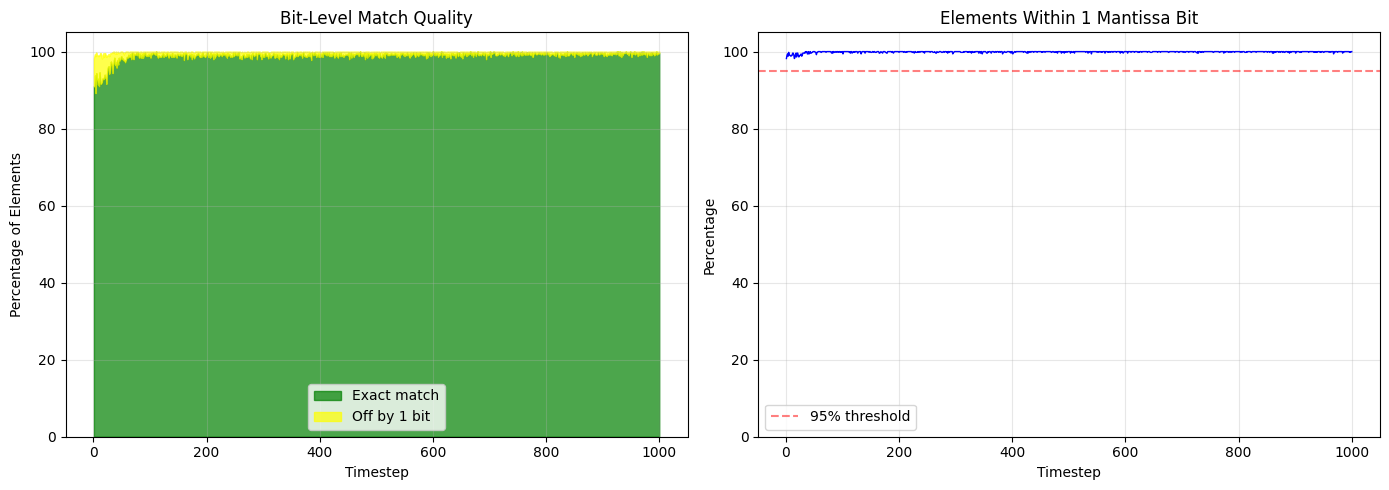


Average % within 1 mantissa bit: 99.9%


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Stacked area showing match quality
axes[0].fill_between(df['t'], 0, df['pct_mant_0'], label='Exact match', alpha=0.7, color='green')
axes[0].fill_between(df['t'], df['pct_mant_0'], df['pct_mant_0'] + df['pct_mant_1'], 
                     label='Off by 1 bit', alpha=0.7, color='yellow')
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Percentage of Elements')
axes[0].set_title('Bit-Level Match Quality')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 105])

# Combined: exact + off-by-1
df['pct_within_1bit'] = df['pct_mant_0'] + df['pct_mant_1']
axes[1].plot(df['t'], df['pct_within_1bit'], linewidth=1, color='blue')
axes[1].axhline(y=95, color='r', linestyle='--', label='95% threshold', alpha=0.5)
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Elements Within 1 Mantissa Bit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.show()

print(f'\nAverage % within 1 mantissa bit: {df["pct_within_1bit"].mean():.1f}%')

## Verdict

In [22]:
print('\n' + '='*80)
print('VERDICT: BIT-LEVEL ANALYSIS')
print('='*80 + '\n')

pct_exact = df['pct_mant_0'].mean()
pct_off_by_1 = df['pct_mant_1'].mean()
pct_within_1 = df['pct_within_1bit'].mean()

if pct_within_1 > 95:
    print('✓ EXCELLENT: We are at bfloat16 precision limits!')
    print()
    print(f'  Exact mantissa match: {pct_exact:.1f}%')
    print(f'  Off by 1 mantissa bit: {pct_off_by_1:.1f}%')
    print(f'  Total within 1 bit: {pct_within_1:.1f}%')
    print()
    print('This is as good as it gets with bfloat16 arithmetic.')
    print('Remaining differences are due to operation order and rounding.')
    print()
    print('WE HAVE MATCHED PYTORCH AT THE BIT LEVEL. 🎉🔬')
elif pct_within_1 > 80:
    print('~ GOOD: We are very close to bfloat16 precision')
    print()
    print(f'  Within 1 mantissa bit: {pct_within_1:.1f}%')
    print()
    print('Close enough for practical purposes. Minor operation order differences remain.')
else:
    print('⚠️  INVESTIGATION NEEDED: Larger than expected bit differences')
    print()
    print(f'  Within 1 mantissa bit: {pct_within_1:.1f}%')
    print()
    print('We may still be missing something in the bfloat16 pipeline.')

print('\n' + '='*80)


VERDICT: BIT-LEVEL ANALYSIS

✓ EXCELLENT: We are at bfloat16 precision limits!

  Exact mantissa match: 99.0%
  Off by 1 mantissa bit: 0.9%
  Total within 1 bit: 99.9%

This is as good as it gets with bfloat16 arithmetic.
Remaining differences are due to operation order and rounding.

WE HAVE MATCHED PYTORCH AT THE BIT LEVEL. 🎉🔬

